In [2]:
%load_ext autoreload
%autoreload 2

from prophet import Prophet
from prophet.make_holidays import make_holidays_df
from prophet.plot import plot_plotly, plot_components_plotly, add_changepoints_to_plot
from statsmodels.graphics.tsaplots import plot_acf

import prophet
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

prophet.__version__, np.__version__

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


('1.1.2', '1.21.6')

# Import Dataset

In [3]:
df = pd.read_csv("./data/pollution.csv", parse_dates=["date"])
df = df.rename(columns={
    "date": "ds",
    "pollution": "y"
})
df = df.resample("M", on="ds").median().reset_index()
df_train = df[df.ds < "2014"]
df_test = df[df.ds >= "2014"]
df_train.shape, df_test.shape

((48, 8), (12, 8))

C:\Users\Rama\miniconda3\envs\ml-practice\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\Rama\miniconda3\envs\ml-practice\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\Rama\miniconda3\envs\ml-practice\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



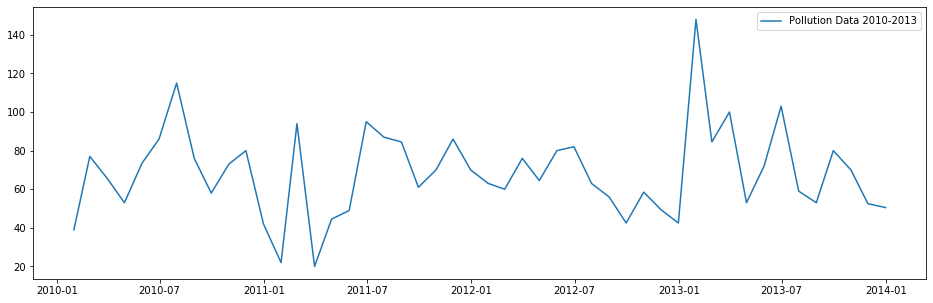

In [259]:
plt.figure(figsize=(16, 5))
plt.plot(df_train.ds, df_train.y, label="Pollution Data 2010-2013")
plt.legend();

# Extract Time Series Component Analysis

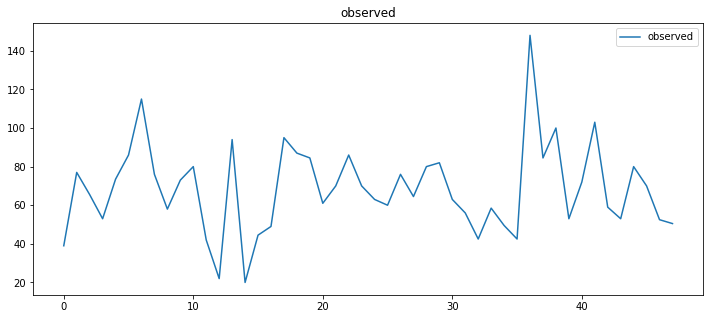

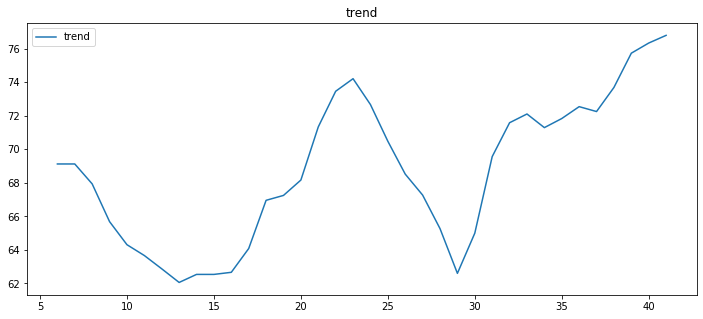

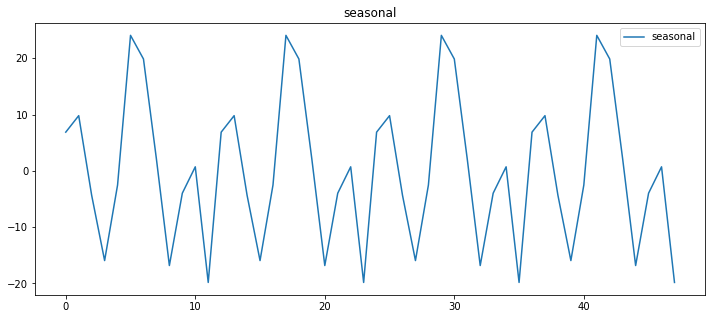

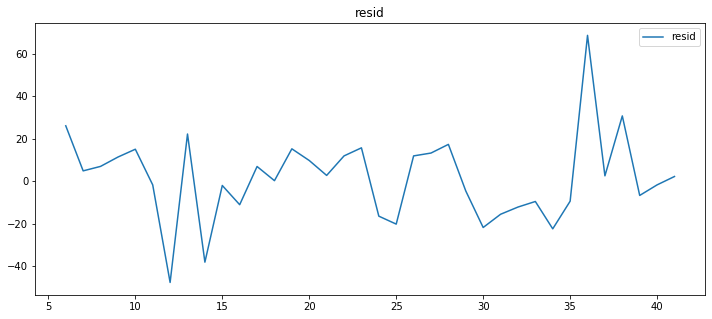

In [260]:
decomposed_df = df_train.copy()
result = seasonal_decompose(decomposed_df.y, model='additive', period=12)
decomposed_df["trend"] = result.trend
decomposed_df["seasonal"] = result.seasonal
decomposed_df["resid"] = result.resid
decomposed_df["observed"] = result.observed

for col in ["observed", "trend", "seasonal", "resid"]:
    decomposed_df.plot(y=col, figsize=(12, 5), title=col)

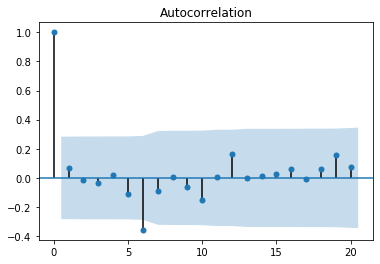

In [261]:
plot_acf(df_train.y, lags=20);

# Data Characteristics

model: `additive`
trend: `no`
seasonality: `no`

# Using Prophet Model

In [275]:
model_config = {
    'holidays': False,
    'general': {
        'growth': 'linear',
        'daily_seasonality': False,
        'weekly_seasonality': False,
        'yearly_seasonality': False
    },
    'seasonality': [
#         {
#            'name': 'daily',
#            'period': 1,
#            'fourier_order': 20,
#            'prior_scale': 25,
#            'mode': 'additive'
#        },
#        {
#            'name': 'weekly',
#            'period': 7,
#            'fourier_order': 15,
#            'prior_scale': 20,
#            'mode': 'additive'
#        },
       {
           'name': 'monthly',
           'period': 4,
           'fourier_order': 20,
           'prior_scale': 50,
           'mode': 'additive'
       },
       {
           'name': 'yearly',
           'period': 12,
           'fourier_order': 30,
           'prior_scale': 40,
           'mode': 'additive'
       }
    ]
}

In [276]:
model = Prophet(**model_config.get('general'))
seasonalities = model_config.get('seasonality')
for seasonality in seasonalities:
    model.add_seasonality(**seasonality)
    
model.add_regressor("snow", mode="additive")
model.add_regressor("dew", mode="additive")
model.add_regressor("temp", mode="additive")
model.add_regressor("press", mode="additive")
model.add_regressor("rain", mode="additive")

model.fit(df_train)

21:03:29 - cmdstanpy - INFO - Chain [1] start processing
21:03:30 - cmdstanpy - INFO - Chain [1] done processing


In [277]:
future.tail()

,ds,y,dew,temp,press,wnd_spd,snow,rain
55,2014-08-31,54.0,18.0,26.0,1008.0,3.130,0.0,0.0
56,2014-09-30,61.0,16.0,20.0,1014.0,3.565,0.0,0.0
57,2014-10-31,102.5,8.0,13.0,1020.0,2.680,0.0,0.0
58,2014-11-30,55.0,-5.0,5.0,1024.0,4.020,0.0,0.0
59,2014-12-31,26.0,-15.0,-2.0,1028.0,8.255,0.0,0.0


In [278]:
future = model.make_future_dataframe(periods=12, freq='M')
future = future.merge(df)
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
55,2014-08-31,61.398269,41.224953,81.214497
56,2014-09-30,99.311046,79.872032,119.143134
57,2014-10-31,87.101883,66.877739,107.798331
58,2014-11-30,52.037756,30.630341,71.106675
59,2014-12-31,46.869611,26.364515,66.382685


C:\Users\Rama\miniconda3\envs\ml-practice\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\Rama\miniconda3\envs\ml-practice\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



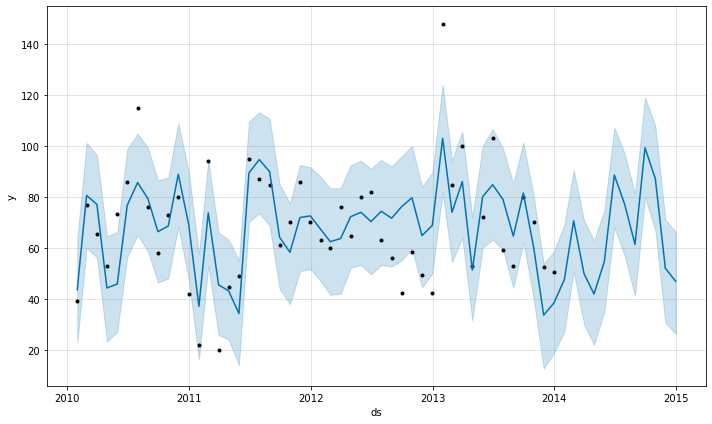

In [279]:
fig1 = model.plot(forecast)

In [280]:
# calculate MAE between observed and predicted values 

def mean_absolute_percentage_error(y_test, pred):
    y_test, pred = np.array(y_test), np.array(pred)
    mape = np.mean(np.abs((y_test - pred) / y_test))
    return mape

y_true = df_train['y'].values
y_pred = forecast[forecast.ds <= df_train.ds.max()]['yhat'].values
mape_01 = mean_absolute_percentage_error(y_true, y_pred)
mape_01

0.22404579734424354